## Лабораторная работа №5
#### По дисциплине "численные методы"
Выполнил: Гаврилов М.С.  
Группа: М8О-406Б-19  
Вариант: 7

In [1]:
import numpy as np
import pylab
from tqdm import tqdm

In [2]:
def visualise(matr,t_skip,shape = [1,1]):
    pylab.figure(figsize = (shape[0],shape[1]))
    pylab.xlabel("x")
    pylab.ylabel("t")
    for i in range(matr.shape[0]):
        if(i % t_skip != 0):
            continue
            
        for j in range(matr.shape[1]):
            
            if(matr[i][j] > 0):
                pylab.plot(j,i,'s',color = (matr[i][j],0,0))
            if(matr[i][j] <= 0):
                pylab.plot(j,i,'s',color = (0,0,-matr[i][j]))
    pylab.show()

In [28]:
class mesh():
    def __init__(self,spatial_resolution,time_resolution,x_span,t_span,approx_method = 0):
        self.type = None
        self.approx = approx_method
        #approx_method - метод аппроксимации, используемый при наличии производных на границе
        #0 - двуточечный  1-го порядка
        #1 - терхточечный 2-го порядка
        #2 - двуточечный  2-го порядка
        
        #x_span = [x0,xl]
        #t_span = [t0,tn]
        self.spatial_resolution = spatial_resolution
        self.time_resolution = time_resolution
        self.x_span = x_span
        self.t_span = t_span
        
        #заполнение координат узлов сетки
        self.mesh_nodes = np.zeros([time_resolution,spatial_resolution,2])
        h = (x_span[1] - x_span[0])/(spatial_resolution-1)
        t = (t_span[1] - t_span[0])/(time_resolution-1)
        self.t = t
        self.h = h
                
        for i in np.arange(time_resolution):
            for j in np.arange(spatial_resolution):
                self.mesh_nodes[i,j,0] = i*t
                self.mesh_nodes[i,j,1] = j*h
                
        self.mesh_nodes_value = np.zeros([time_resolution,spatial_resolution])
        
    def set_f0(self,f0): #f0 - функия, принимающая в качестве аргумента пространственную координату
        for j in range(self.spatial_resolution):
            self.mesh_nodes_value[0,j] = f0(self.mesh_nodes[0,j,1])
        
    def set_border_val(self,f0,fl):
        for i in range(self.time_resolution):
            self.mesh_nodes_value[i,0] = f0(self.mesh_nodes[i,0,0])
            self.mesh_nodes_value[i,self.spatial_resolution - 1] = f0(self.mesh_nodes[i,self.spatial_resolution - 1,0])
        self.type = 1
        
    def set_border_drv(self,f0,fl):
        self.fx0 = f0
        self.fxl = fl
        self.type = 2
        
    def set_mesh_values(self,vals):
        
        for i in range(self.time_resolution):
            for j in range(0, self.spatial_resolution):
                self.mesh_nodes_value[i,j] = vals(self.mesh_nodes[i,j])
        
    def explicit_finite_dif_solve(self,a,b = 0,c = 0,f = None,verbal = False):
        sigma = ((a) * self.t)/(self.h**2)
        h = self.h
        t = self.t
        
        if(verbal):
            if(sigma > 0.5):
                print("alert: sigma = {}. invalid solution".format(sigma))
        else:
            if(sigma > 0.5):
                return
                
        l = self.spatial_resolution
        
        for i in range(self.time_resolution - 1):
            for j in range(1, self.spatial_resolution - 1):
                self.mesh_nodes_value[i+1,j] = sigma*self.mesh_nodes_value[i,j+1] + sigma*self.mesh_nodes_value[i,j-1] + (1 - 2*sigma)*self.mesh_nodes_value[i,j] 
                if(f != None):
                    self.mesh_nodes_value[i + 1,j] += self.t*f(self.mesh_nodes[i+1,j])
        
            if(self.type == 2):
                if(self.approx == 0):
                    self.mesh_nodes_value[i + 1,0]   = self.mesh_nodes_value[i + 1,1] -self.h*self.fx0(self.mesh_nodes[i + 1,0,0])
                    self.mesh_nodes_value[i + 1,l-1] = self.mesh_nodes_value[i + 1,l-2] + self.h*self.fxl(self.mesh_nodes[i + 1,l-1,0])
                if(self.approx == 1):
                    self.mesh_nodes_value[i + 1,0]   = (4*self.mesh_nodes_value[i + 1,1] - self.mesh_nodes_value[i + 1,2] -2*self.h*self.fx0(self.mesh_nodes[i + 1,0,0]))/3
                    self.mesh_nodes_value[i + 1,l-1] = (4*self.mesh_nodes_value[i + 1,l-2] - self.mesh_nodes_value[i + 1,l-3] + 2*self.h*self.fxl(self.mesh_nodes[i + 1,l-1,0]))/3
                if(self.approx == 2):               
                    self.mesh_nodes_value[i + 1,0] = (self.mesh_nodes_value[i + 1,1] + ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,0] - h*(1 +(h*b)/(2*a**2))*self.fx0(self.mesh_nodes[i + 1,0,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,0])))/(1 + (h**2)/(2*t*a**2))
                    self.mesh_nodes_value[i + 1,l-1] = (self.mesh_nodes_value[i + 1,l-2] + ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,l-1] + h*(1 -(h*b)/(2*a**2))*self.fxl(self.mesh_nodes[i + 1,l-1,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,l-1])))/(1 + (h**2)/(2*t*a**2))
                    
                    
    def implicit_finite_dif_solve(self,a,b=0,c=0,f = None):
        t = self.t
        h = self.h
        l = self.spatial_resolution
        alpha = (((a*t) / (h**2)) - ((b*t) / (2*h)))
        betha = (-1 - ((2*a*t) / (h**2)) + c*t)
        gamma = (((a*t) / (h**2)) + ((b*t) / (2*h)))
        
        for i in range(self.time_resolution - 1):
            matr = np.zeros([self.spatial_resolution,self.spatial_resolution])
            res = np.zeros([self.spatial_resolution])

            if(self.type == 1):
                matr[0,0] = 1
                matr[l-1,l-1] = 1

                res[0]  = self.mesh_nodes_value[i + 1,0  ]
                res[l-1]= self.mesh_nodes_value[i + 1,l-1]

            if(self.type == 2):
                if(self.approx == 0):
                    matr[0,0] =  1
                    matr[0,1] = -1 
                    matr[l-1,l-2] = -1
                    matr[l-1,l-1] =  1

                    res[0]   =  -h*self.fx0(self.mesh_nodes[i+1,0,0])
                    res[l-1] =  h*self.fxl(self.mesh_nodes[i+1,l-1,0])
                if(self.approx == 1):
                    matr[0,0] = -3
                    matr[0,1] = +4
                    matr[0,2] = -1 
                    matr[l-1,l-3] = +1
                    matr[l-1,l-2] = -4
                    matr[l-1,l-1] = +3

                    res[0]   =  2*h*self.fx0(self.mesh_nodes[i+1,0,0])
                    res[l-1] =  2*h*self.fxl(self.mesh_nodes[i+1,l-1,0])
                if(self.approx == 2):
                    matr[0,0] =  (1 + (h**2)/(2*t*a**2))
                    matr[0,1] = -1 
                    matr[l-1,l-2] = -1
                    matr[l-1,l-1] =  (1 + (h**2)/(2*t*a**2))
                    
                    res[0]   =  ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,0] - h*(1 +(h*b)/(2*a**2))*self.fx0(self.mesh_nodes[i + 1,0,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,0]))
                    res[l-1] =  ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,l-1] + h*(1 -(h*b)/(2*a**2))*self.fxl(self.mesh_nodes[i + 1,l-1,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,l-1]))

            for j in range(1,l-1):
                matr[j,j-1] = alpha
                matr[j,j+0] = betha
                matr[j,j+1] = gamma

                res[j] = -self.mesh_nodes_value[i,j]
                if(f != None):
                    res[j] -= t*f(self.mesh_nodes[i+1,j])

            next_row = np.linalg.solve(matr,res)
            self.mesh_nodes_value[i + 1] = next_row
            
    def combined_finite_dif_solve(self,a,b=0,c=0,f=None,theta = 0.5): #b и c для красоты
        t = self.t
        h = self.h
        l = self.spatial_resolution
        sigma = (a*t) / (h**2)
        alpha = theta*sigma
        betha = -1 - 2*theta*sigma
        gamma = theta*sigma
        
        for i in range(self.time_resolution - 1):
            matr = np.zeros([self.spatial_resolution,self.spatial_resolution])
            res = np.zeros([self.spatial_resolution])

            if(self.type == 1):
                matr[0,0] = 1
                matr[l-1,l-1] = 1

                res[0]  = self.mesh_nodes_value[i + 1,0  ]
                res[l-1]= self.mesh_nodes_value[i + 1,l-1]

            if(self.type == 2):
                if(self.approx == 0):
                    matr[0,0] =  1
                    matr[0,1] = -1 
                    matr[l-1,l-2] = -1
                    matr[l-1,l-1] =  1

                    res[0]   =  -h*self.fx0(self.mesh_nodes[i+1,0,0])
                    res[l-1] =  h*self.fxl(self.mesh_nodes[i+1,l-1,0])
                if(self.approx == 1):
                    matr[0,0] = -3
                    matr[0,1] = +4
                    matr[0,2] = -1 
                    matr[l-1,l-3] = +1
                    matr[l-1,l-2] = -4
                    matr[l-1,l-1] = +3

                    res[0]   =  2*h*self.fx0(self.mesh_nodes[i+1,0,0])
                    res[l-1] =  2*h*self.fxl(self.mesh_nodes[i+1,l-1,0])
                if(self.approx == 2):
                    matr[0,0] =  (1 + (h**2)/(2*t*a**2))
                    matr[0,1] = -1 
                    matr[l-1,l-2] = -1
                    matr[l-1,l-1] =  (1 + (h**2)/(2*t*a**2))
                    
                    res[0]   =  ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,0] - h*(1 +(h*b)/(2*a**2))*self.fx0(self.mesh_nodes[i + 1,0,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,0]))
                    res[l-1] =  ((h**2)/(2*t*a**2))*self.mesh_nodes_value[i,l-1] + h*(1 -(h*b)/(2*a**2))*self.fxl(self.mesh_nodes[i + 1,l-1,0]) - (h/(2*a**2))*(c + f(self.mesh_nodes[i+1,l-1]))


            for j in range(1,l-1):
                matr[j,j-1] = alpha
                matr[j,j+0] = betha
                matr[j,j+1] = gamma

                res[j] = -self.mesh_nodes_value[i,j]
                res[j] -= (1-theta)*sigma*(self.mesh_nodes_value[i,j+1]-2*self.mesh_nodes_value[i,j]+self.mesh_nodes_value[i,j-1])
                if(f != None):
                    res[j] -= t*f(self.mesh_nodes[i,j])

            next_row = np.linalg.solve(matr,res)
            self.mesh_nodes_value[i + 1] = next_row
        
    
    def print(self,skip = 1):
        vis_mesh = self.mesh_nodes_value / np.max(np.abs(self.mesh_nodes_value))
        visualise(vis_mesh,t_skip = skip,shape = [self.x_span[1] - self.x_span[0],self.t_span[1] - self.t_span[0]])
        
    def compare(self,other):
        return np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))
        
    def compare_verbal(self,other,skip = 10):
        print("mean abs error: {}".format(np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))))
        print("error map:")
        dif_mesh = (self.mesh_nodes_value - other.mesh_nodes_value)
        dif_mesh = dif_mesh / np.max(np.abs(dif_mesh))
        visualise(dif_mesh,t_skip = skip,shape = [self.x_span[1] - self.x_span[0],self.t_span[1] - self.t_span[0]])
        
        return np.mean(np.abs(self.mesh_nodes_value - other.mesh_nodes_value))
        

In [29]:
def f_x(crd):
    t,x = crd
    return 0.5*np.exp(-0.5*t)*np.sin(x)

def f_0(x):
    return np.sin(x)

def x_0(t): # > 0 --> энергия утекает, < 0 --> энергия притекает
    return np.exp(-0.5*t)

def x_l(t): # < 0 --> энергия утекает, > 0 --> энергия притекает
    return -np.exp(-0.5*t)

### Решения, полученные разностными методами

#### Явный метод

In [30]:
exsl_mesh = mesh(25,1300,[0,np.pi],[0,10])
exsl_mesh.set_f0(f_0)
exsl_mesh.set_border_drv(x_0,x_l)

In [31]:
exsl_mesh.explicit_finite_dif_solve(1,f = f_x)

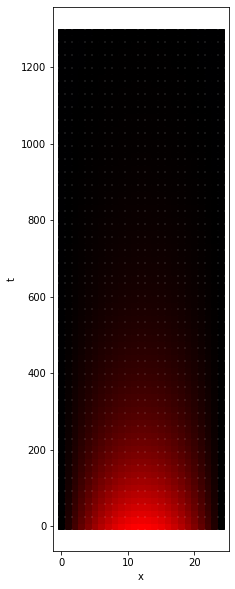

In [32]:
exsl_mesh.print(skip = 17)

#### Неявный метод

In [33]:
imsl_mesh = mesh(25,1300,[0,np.pi],[0,10])
imsl_mesh.set_f0(f_0)
imsl_mesh.set_border_drv(x_0,x_l)

In [34]:
imsl_mesh.implicit_finite_dif_solve(1,f = f_x)

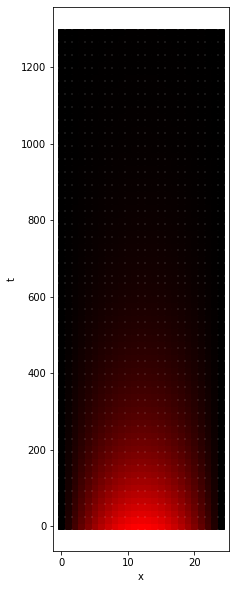

In [35]:
imsl_mesh.print(skip = 17)

#### Комбинированный метод

In [36]:
cmsl_mesh = mesh(25,1300,[0,np.pi],[0,10])
cmsl_mesh.set_f0(f_0)
cmsl_mesh.set_border_drv(x_0,x_l)

In [37]:
cmsl_mesh.combined_finite_dif_solve(1,f = f_x)

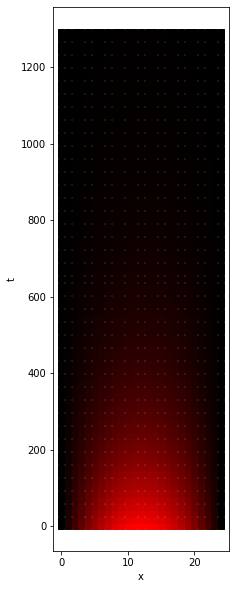

In [38]:
cmsl_mesh.print(skip = 17)

### Истинное решение

In [39]:
def sol(crd):
    t,x = crd
    return np.exp(-0.5*t)*np.sin(x)

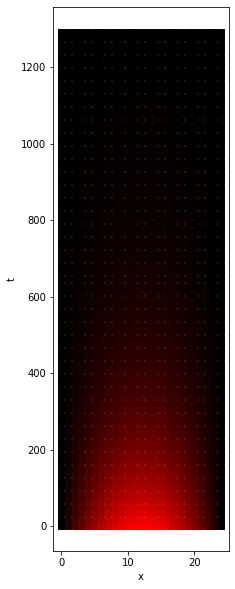

In [40]:
real_sol = mesh(25,1300,[0,np.pi],[0,10])
real_sol.set_mesh_values(sol)
real_sol.print(skip = 17)

### Сравнение с истинныым решением

#### Явный метод

mean abs error: 0.004600966942491745
error map:


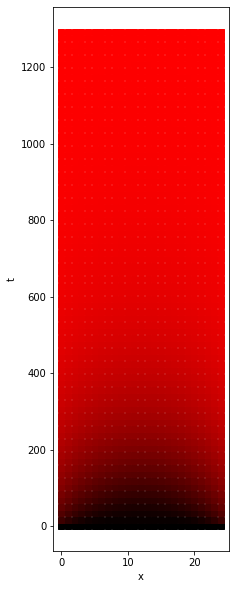

In [41]:
er_ex_0 = real_sol.compare_verbal(exsl_mesh,skip = 17)

#### Неявный метод

mean abs error: 0.0005593477678496438
error map:


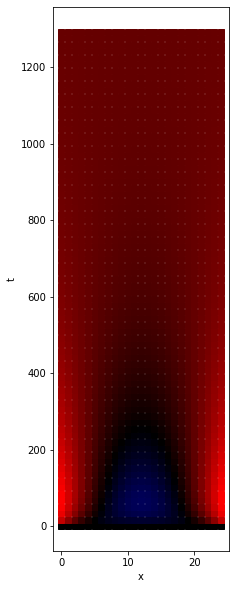

In [42]:
er_im_0 = real_sol.compare_verbal(imsl_mesh,skip = 17)

#### Комбинированный метод

mean abs error: 0.0005559805094610557
error map:


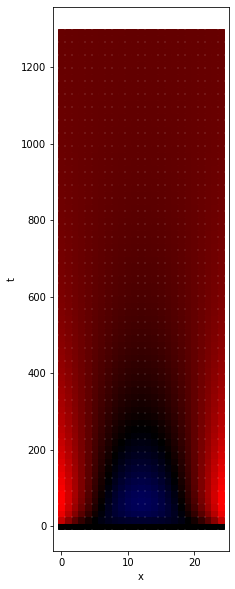

In [43]:
er_co_0 = real_sol.compare_verbal(cmsl_mesh,skip = 17)

#### Видно, что явный метод дает положительную ошибку, неявный - отрицательную, а комбинированный - наименьшую ошибку, имеющую разные знаки в различных чатях сетки

### Трехточечная аппроксимация

In [44]:
exsl_mesh = mesh(25,1300,[0,np.pi],[0,10],approx_method=1)
exsl_mesh.set_f0(f_0)
exsl_mesh.set_border_drv(x_0,x_l)

In [45]:
exsl_mesh.explicit_finite_dif_solve(1,f = f_x)

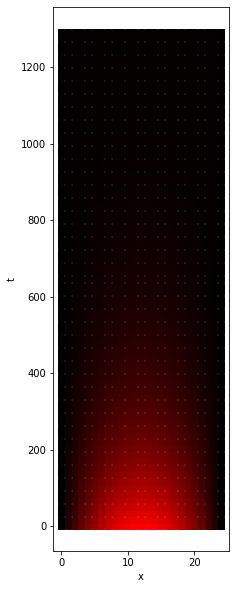

In [46]:
exsl_mesh.print(skip = 17)

mean abs error: 0.004311436430295228
error map:


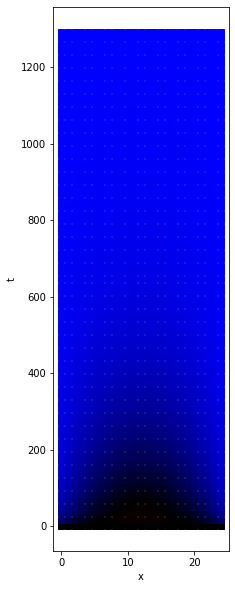

In [47]:
er_ex_1 = real_sol.compare_verbal(exsl_mesh,skip = 17)

In [192]:
imsl_mesh = mesh(25,1300,[0,np.pi],[0,10],approx_method=1)
imsl_mesh.set_f0(f_0)
imsl_mesh.set_border_drv(x_0,x_l)

In [193]:
imsl_mesh.implicit_finite_dif_solve(1,f = f_x)

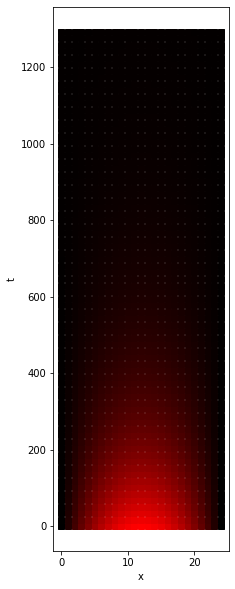

In [194]:
imsl_mesh.print(skip = 17)

mean abs error: 0.008258104048033461
error map:


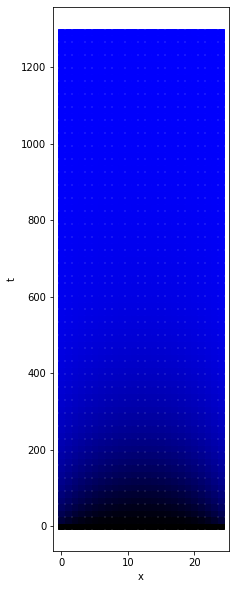

In [195]:
er_im_1 = real_sol.compare_verbal(imsl_mesh,skip = 17)

In [196]:
cmsl_mesh = mesh(25,1300,[0,np.pi],[0,10],approx_method=1)
cmsl_mesh.set_f0(f_0)
cmsl_mesh.set_border_drv(x_0,x_l)

In [197]:
cmsl_mesh.combined_finite_dif_solve(1,f = f_x)

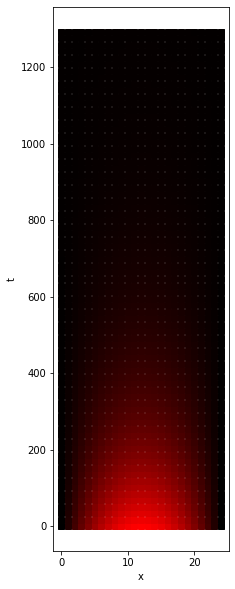

In [198]:
cmsl_mesh.print(skip = 17)

mean abs error: 0.008258166710237136
error map:


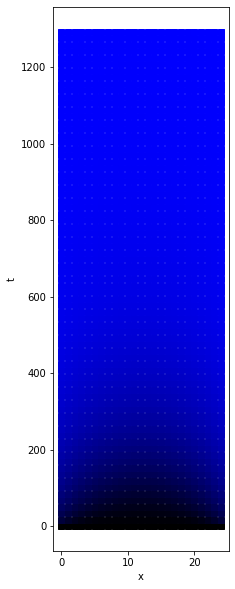

In [199]:
er_co_1 = real_sol.compare_verbal(cmsl_mesh,skip = 17)

### Двухточечная аппроксимация второго порядка

#### Явный метод

In [221]:
exsl_mesh = mesh(25,1300,[0,np.pi],[0,10],approx_method=2)
exsl_mesh.set_f0(f_0)
exsl_mesh.set_border_drv(x_0,x_l)

In [222]:
exsl_mesh.explicit_finite_dif_solve(1,f = f_x)

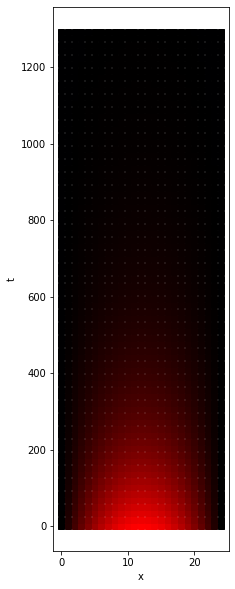

In [223]:
exsl_mesh.print(skip = 17)

mean abs error: 0.004397394125112496
error map:


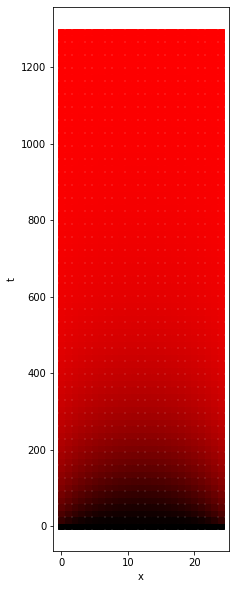

In [224]:
er_ex_2 = real_sol.compare_verbal(exsl_mesh,skip = 17)

Это наиболее точное решение из всех, полученных явным методом. Впрочем, тольность лишь немного лучше двухточечной аппроксимации

#### Неявный метод

In [213]:
exsl_mesh = mesh(25,1300,[0,np.pi],[0,10],approx_method=2)
exsl_mesh.set_f0(f_0)
exsl_mesh.set_border_drv(x_0,x_l)

In [214]:
exsl_mesh.implicit_finite_dif_solve(1,f = f_x)

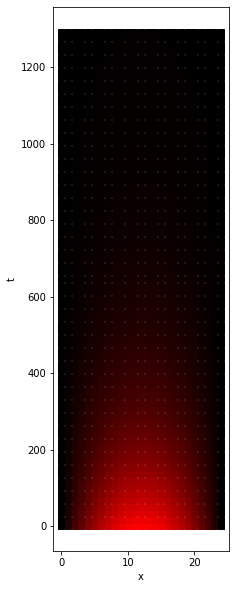

In [215]:
exsl_mesh.print(skip = 17)

mean abs error: 0.0005307140118146265
error map:


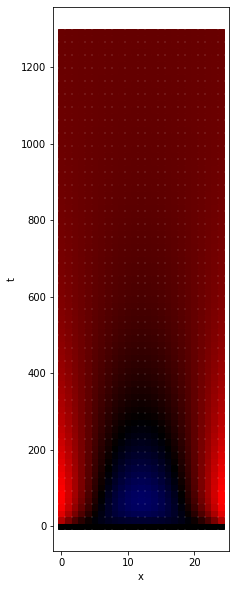

In [216]:
er_im_2 = real_sol.compare_verbal(exsl_mesh,skip = 17)

#### Комбинированый метод

In [217]:
exsl_mesh = mesh(25,1300,[0,np.pi],[0,10],approx_method=2)
exsl_mesh.set_f0(f_0)
exsl_mesh.set_border_drv(x_0,x_l)

In [218]:
exsl_mesh.combined_finite_dif_solve(1,f = f_x)

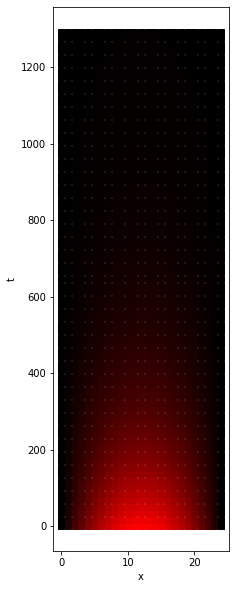

In [219]:
exsl_mesh.print(skip = 17)

mean abs error: 0.000527593497740356
error map:


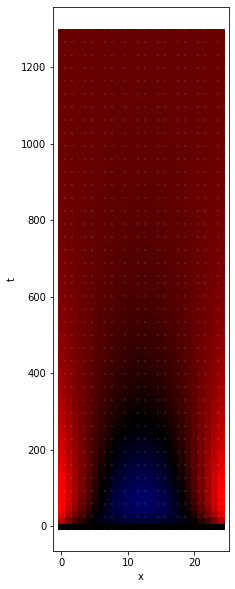

In [220]:
er_co_2 = real_sol.compare_verbal(exsl_mesh,skip = 17)

## Результаты

Сравнение всех методов решения и аппроксимаци (по погрешности)

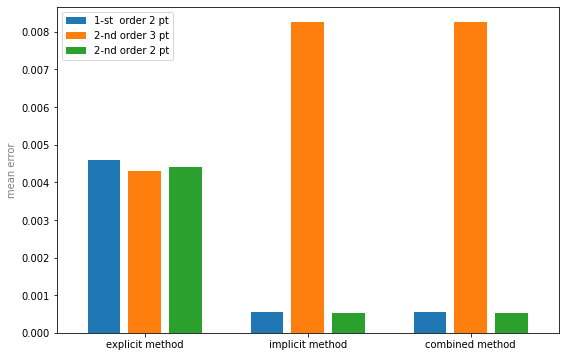

In [266]:
pylab.figure(figsize = (9,6))
pylab.bar([1/4,1 + 1/4,2 + 1/4],[er_ex_0,er_im_0,er_co_0],width = 1/5,align = 'center',label = "1-st  order 2 pt")
pylab.bar([2/4,1 + 2/4,2 + 2/4],[er_ex_1,er_im_1,er_co_1],width = 1/5,align = 'center',label = "2-nd order 3 pt")
pylab.bar([3/4,1 + 3/4,2 + 3/4],[er_ex_2,er_im_2,er_co_2],width = 1/5,align = 'center',label = "2-nd order 2 pt")
pylab.bar([0.5,1.5,2.5],[0,0,0],tick_label = ["explicit method","implicit method","combined method"])
pylab.legend()
pylab.ylabel("mean error",color = [0.5,0.5,0.5])
pylab.show()

Сравнение аппроксимации производных первого и второго порядка точности, дабы убедиться, что последний дает меньшую погрешность

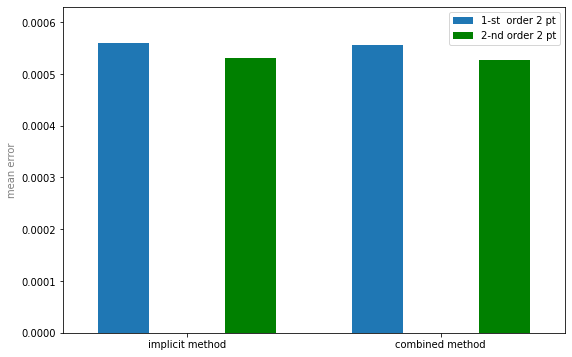

In [278]:
pylab.figure(figsize = (9,6))
pylab.bar([1.5,2.5],[0,0.0006],color = [1,1,1],tick_label = ["implicit method","combined method"])
pylab.bar([1 + 1/4,2 + 1/4],[er_im_0,er_co_0],width = 1/5,align = 'center',label = "1-st  order 2 pt")
pylab.bar([1 + 3/4,2 + 3/4],[er_im_2,er_co_2],width = 1/5,align = 'center',label = "2-nd order 2 pt",color = "green")
pylab.legend()
pylab.ylabel("mean error",color = [0.5,0.5,0.5])
pylab.show()

## Зависимость погрешности от шага сетки

Используем комбинированный метод с двухточечной аппроксимацией производной второго порядка точности. (метод с наименьшей погрешностью)
Для простоты используется квадратная сетка.

In [283]:
arr = []
for i in tqdm(range(10,500,20)):
    
    exsl_mesh = mesh(i,i,[0,np.pi],[0,10],approx_method=2)
    exsl_mesh.set_f0(f_0)
    exsl_mesh.set_border_drv(x_0,x_l)
    
    ril_mesh = mesh(i,i,[0,np.pi],[0,10],approx_method=2)
    ril_mesh.set_mesh_values(sol)

    exsl_mesh.combined_finite_dif_solve(1,f = f_x)
    err = ril_mesh.compare(exsl_mesh)
    arr.append([i,err])
    
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [03:49<00:00,  9.20s/it]


График зависимости погрешности от количества узлов в стороне сетки:

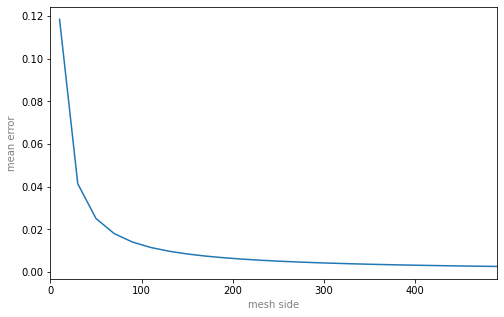

In [297]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1])
pylab.show()

Сравним различные методы:

In [309]:
arr = []
for i in tqdm(range(10,500,20)):
    
    exsl_mesh = mesh(i,i,[0,np.pi],[0,10],approx_method=2)
    exsl_mesh.set_f0(f_0)
    exsl_mesh.set_border_drv(x_0,x_l)
    
    imsl_mesh = mesh(i,i,[0,np.pi],[0,10],approx_method=2)
    imsl_mesh.set_f0(f_0)
    imsl_mesh.set_border_drv(x_0,x_l)
    
    cosl_mesh = mesh(i,i,[0,np.pi],[0,10],approx_method=2)
    cosl_mesh.set_f0(f_0)
    cosl_mesh.set_border_drv(x_0,x_l)
    
    ril_mesh = mesh(i,i,[0,np.pi],[0,10],approx_method=2)
    ril_mesh.set_mesh_values(sol)

    exsl_mesh.explicit_finite_dif_solve(1,f = f_x)
    imsl_mesh.implicit_finite_dif_solve(1,f = f_x)
    cosl_mesh.combined_finite_dif_solve(1,f = f_x)
    err1 = ril_mesh.compare(exsl_mesh)
    err2 = ril_mesh.compare(imsl_mesh)
    err3 = ril_mesh.compare(cosl_mesh)
    arr.append([i,err1,err2,err3])
    
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [05:36<00:00, 13.46s/it]


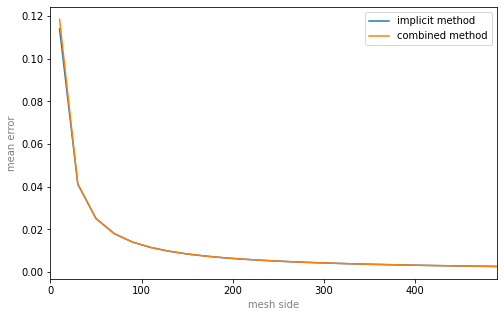

In [314]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,2],label = "implicit method")
pylab.plot(arr[:,0],arr[:,3],label = "combined method")
pylab.legend()
pylab.show()

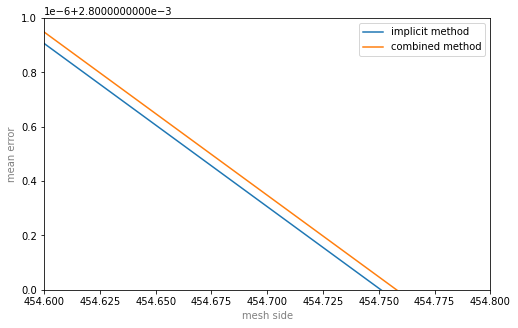

In [346]:
pylab.figure(figsize = (8,5))
pylab.xlabel("mesh side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(454.6,454.8)
pylab.ylim(0.0028,0.002801)
pylab.plot(arr[:,0],arr[:,2],label = "implicit method")
pylab.plot(arr[:,0],arr[:,3],label = "combined method")
pylab.legend()
pylab.show()

Видно, что погрешности неявного и комбинированного метода ведут себя почти одинакого (явный метод нельзя выполнить на квадратной сетке)

Сравним результаты при зафиксированном временном и пространственном разрешении сетки

In [305]:
arr = []
for i in tqdm(range(10,500,20)):
    
    ril_mesh = mesh(100,i,[0,np.pi],[0,10],approx_method=2)
    ril_mesh.set_mesh_values(sol)
    exsl_mesh = mesh(100,i,[0,np.pi],[0,10],approx_method=2)
    exsl_mesh.set_f0(f_0)
    exsl_mesh.set_border_drv(x_0,x_l)
    
    exsl_mesh.combined_finite_dif_solve(1,f = f_x)
    err1 = ril_mesh.compare(exsl_mesh)
    
    ril_mesh = mesh(i,500,[0,np.pi],[0,10],approx_method=2)
    ril_mesh.set_mesh_values(sol)
    exsl_mesh = mesh(i,500,[0,np.pi],[0,10],approx_method=2)
    exsl_mesh.set_f0(f_0)
    exsl_mesh.set_border_drv(x_0,x_l)
    
    exsl_mesh.combined_finite_dif_solve(1,f = f_x)
    err2 = ril_mesh.compare(exsl_mesh)

    arr.append([i,err1,err2])
    
arr = np.array(arr)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [10:31<00:00, 25.25s/it]


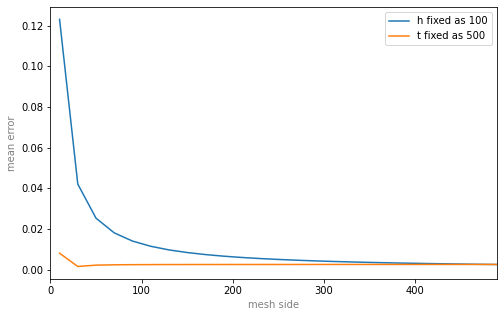

In [306]:
pylab.figure(figsize = (8,5))
pylab.xlabel("other side",color = "grey")
pylab.ylabel("mean error",color = "grey")
pylab.xlim(0,np.max(arr[:,0]))
pylab.plot(arr[:,0],arr[:,1],label = "h fixed as 100")
pylab.plot(arr[:,0],arr[:,2],label = "t fixed as 500")
pylab.legend()
pylab.show()

можно сделать вывод, что, за исключением, крайне крупных сеток, высокая точность решения достигается установлением значеня t << h, а также, большое значение t наносит куда больший вред точности решения, чем большое значение h.